# Compile CBS Proximity datasets into one wide dataset

This notebook:
1. Reads all CSV files in the current folder that start with **`Proximity - Regional designation`**
2. Cleans/standardizes identifiers
3. Merges all indicator columns into one *wide* dataset
4. Saves the result as a CSV (and optionally Parquet)
5. Produces a few example exploratory plots



In [9]:
import os
import re
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path("../data/proximity/")  
paths = sorted(DATA_DIR.glob("*.csv"))
paths

[WindowsPath('../data/proximity/Proximity - Regional designation - Education.csv'),
 WindowsPath('../data/proximity/Proximity - Regional designation - Green areas.csv'),
 WindowsPath('../data/proximity/Proximity - Regional designation - Health and Wellbeing.csv'),
 WindowsPath('../data/proximity/Proximity - Regional designation - Retail.csv'),
 WindowsPath('../data/proximity/Proximity - Regional designation - Transport.csv'),
 WindowsPath('../data/proximity/Proximity - Regional designation.csv')]

In [10]:
def read_cbs_csv(path: str) -> pd.DataFrame:
    """Read CBS-style CSVs (semicolon-separated, decimal comma) robustly."""
    return pd.read_csv(
        path,
        sep=";",
        engine="python",
        encoding="utf-8-sig",
        decimal=",",
        on_bad_lines="skip",
    )

def find_year_column(df: pd.DataFrame) -> str | None:
    candidates = []
    for c in df.columns:
        if re.search(r"\b(perioden|periode|jaar|year)\b", c, flags=re.I):
            candidates.append(c)
    return candidates[0] if candidates else None

ID_COLS_BASE = [
    "Wijken en buurten",
    "Regioaanduiding/Gemeentenaam (naam)",
    "Regioaanduiding/Soort regio (omschrijving)",
    "Regioaanduiding/Codering (code)",
    "Regioaanduiding/Indelingswijziging wijken en buurten (code)",
]

def standardize(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize identifiers and add a `year` column if possible."""
    df = df.copy()
    year_col = find_year_column(df)
    if year_col is not None:
        # Try to extract a 4-digit year if the column is like '2023' or '2023JJ00'
        df["year"] = (
            df[year_col]
            .astype(str)
            .str.extract(r"(19\d{2}|20\d{2})", expand=False)
        )
        df.drop(columns=[year_col], inplace=True)
    else:
        df["year"] = np.nan  # constant if no year column is present

    # Clean region code and names a bit
    code_col = "Regioaanduiding/Codering (code)"
    if code_col in df.columns:
        df[code_col] = df[code_col].astype(str).str.strip()

    for c in ["Wijken en buurten", "Regioaanduiding/Gemeentenaam (naam)"]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()

    return df

def indicator_columns(df: pd.DataFrame) -> list[str]:
    id_cols = set(ID_COLS_BASE + ["year"])
    return [c for c in df.columns if c not in id_cols]


In [11]:
# Read and merge all files
frames = []
for path in paths:
    df = standardize(read_cbs_csv(path))
    inds = indicator_columns(df)

    # Prefix indicator column names by category inferred from filename
    fname = os.path.basename(path)
    # e.g. "Proximity - Regional designation - Retail.csv" -> "Retail"
    m = re.search(r"Proximity - Regional designation(?: - (.*))?\.csv$", fname)
    category = (m.group(1) if m and m.group(1) else "Base").strip()

    rename_map = {c: f"{category} | {c}" for c in inds}
    df = df[ID_COLS_BASE + ["year"] + inds].rename(columns=rename_map)

    frames.append(df)

# Merge on neighbourhood code + year (and keep descriptive columns)
from functools import reduce

KEY_COLS = ["Regioaanduiding/Codering (code)", "year"]
DESC_COLS = [c for c in ID_COLS_BASE if c != KEY_COLS[0]]

def merge_two(left: pd.DataFrame, right: pd.DataFrame) -> pd.DataFrame:
    # Ensure we don't duplicate description columns during merge
    drop_desc = [c for c in DESC_COLS if c in right.columns]
    right2 = right.drop(columns=drop_desc, errors="ignore")
    return left.merge(right2, on=KEY_COLS, how="outer")

wide = reduce(merge_two, frames)

# Bring description columns to the front (prefer non-null from any frame)
# We'll reconstruct a single set of description columns by taking first non-null across frames.
desc_parts = []
for df in frames:
    cols = [KEY_COLS[0]] + DESC_COLS + ["year"]
    cols = [c for c in cols if c in df.columns]
    desc_parts.append(df[cols])

desc = pd.concat(desc_parts, ignore_index=True)
desc = desc.groupby(KEY_COLS, dropna=False).agg(lambda s: s.dropna().iloc[0] if s.dropna().size else np.nan).reset_index()

# Attach descriptions back
wide = wide.drop(columns=[c for c in DESC_COLS if c in wide.columns], errors="ignore")
wide = desc.merge(wide, on=KEY_COLS, how="right")

wide.shape, wide.columns[:10]


((18310, 69),
 Index(['Regioaanduiding/Codering (code)', 'year', 'Wijken en buurten',
        'Regioaanduiding/Gemeentenaam (naam)',
        'Regioaanduiding/Soort regio (omschrijving)',
        'Regioaanduiding/Indelingswijziging wijken en buurten (code)',
        'Education | Onderwijs/Basisonderwijs/Afstand tot school (km)',
        'Education | Onderwijs/Basisonderwijs/Aantal scholen/Binnen 1 km (aantal)',
        'Education | Onderwijs/Basisonderwijs/Aantal scholen/Binnen 3 km (aantal)',
        'Education | Onderwijs/Basisonderwijs/Aantal scholen/Binnen 5 km (aantal)'],
       dtype='object'))

In [12]:
# Quick sanity checks
wide.head()


,Regioaanduiding/Codering (code),year,Wijken en buurten,Regioaanduiding/Gemeentenaam (naam),Regioaanduiding/Soort regio (omschrijving),Regioaanduiding/Indelingswijziging wijken en buurten (code),Education | Onderwijs/Basisonderwijs/Afstand tot school (km),Education | Onderwijs/Basisonderwijs/Aantal scholen/Binnen 1 km (aantal),Education | Onderwijs/Basisonderwijs/Aantal scholen/Binnen 3 km (aantal),Education | Onderwijs/Basisonderwijs/Aantal scholen/Binnen 5 km (aantal),...,Retail | Detailhandel/Winkels dagelijkse boodschappen/Aantal overige dagelijkse levensmiddelen/Binnen 1 km (aantal),Retail | Detailhandel/Winkels dagelijkse boodschappen/Aantal overige dagelijkse levensmiddelen/Binnen 3 km (aantal),Retail | Detailhandel/Winkels dagelijkse boodschappen/Aantal overige dagelijkse levensmiddelen/Binnen 5 km (aantal),Retail | Detailhandel/Warenhuis/Afstand tot warenhuis (km),Retail | Detailhandel/Warenhuis/Aantal warenhuizen/Binnen 5 km (aantal),Retail | Detailhandel/Warenhuis/Aantal warenhuizen/Binnen 10 km (aantal),Retail | Detailhandel/Warenhuis/Aantal warenhuizen/Binnen 20 km (aantal),Transport | Verkeer en vervoer/Afstand tot oprit hoofdverkeersweg (km),Transport | Verkeer en vervoer/Treinstations/Afstand tot treinstations totaal (km),Transport | Verkeer en vervoer/Treinstations/Afstand tot belangrijk overstapstation (km)
0,BU00140000,NaN,Binnenstad-Noord,Groningen,Buurt,1,0.5,1.8,16.1,25.4,...,50.7,126.6,152.8,0.9,5.0,7.0,14.0,1.8,1.3,1.3
1,BU00140001,NaN,Binnenstad-Zuid,Groningen,Buurt,1,0.8,1.5,14.4,25.1,...,44.8,127.9,149.5,0.9,5.0,7.0,14.0,1.4,0.9,0.9
2,BU00140002,NaN,Binnenstad-Oost,Groningen,Buurt,1,0.8,1.5,14.8,26.3,...,31.5,117.2,151.3,1.1,5.0,7.0,14.0,1.6,1.6,1.7
3,BU00140003,NaN,Binnenstad-West,Groningen,Buurt,1,1.0,0.5,13.9,27.5,...,31.0,128.3,150.6,1.1,5.0,7.0,14.0,1.4,0.9,0.9
4,BU00140004,NaN,Noorderplantsoen,Groningen,Buurt,1,0.4,1.4,16.0,27.0,...,26.6,126.0,150.0,1.3,5.0,7.0,14.0,1.5,1.3,1.3


In [13]:
# How many indicators?
indicator_cols = [c for c in wide.columns if c not in (DESC_COLS + KEY_COLS)]
len(indicator_cols)


63

In [14]:
# Missingness overview (top 20 most-missing indicators)
missing = wide[indicator_cols].isna().mean().sort_values(ascending=False)
missing.head(20)


Green areas | Groenvoorzieningen/Openbaar groen/Afstand tot open natuurlijk terrein/Afstand tot open nat natuurlijk terrein (km)    1.000000
Green areas | Groenvoorzieningen/Openbaar groen/Afstand tot open natuurlijk terrein/Afstand tot open nat. terrein totaal (km)       1.000000
Green areas | Groenvoorzieningen/Afstand tot recreatief binnenwater (km)                                                            1.000000
Green areas | Groenvoorzieningen/Semi-openbaar groen/Afstand tot verblijfsrecreatief terrein (km)                                   1.000000
Green areas | Groenvoorzieningen/Semi-openbaar groen/Afstand tot volkstuin (km)                                                     1.000000
Green areas | Groenvoorzieningen/Semi-openbaar groen/Afstand tot sportterrein (km)                                                  1.000000
Green areas | Groenvoorzieningen/Semi-openbaar groen/Afstand tot begraafplaats (km)                                                 1.000000
Green areas |

## Save the compiled dataset

In [15]:
OUT_CSV = "../data/processed/proximity_compiled_wide.csv"
wide.to_csv(OUT_CSV, index=False)
OUT_CSV


'../data/processed/proximity_compiled_wide.csv'

## Example exploratory plots

These examples pick a couple of numeric indicators automatically.  
If you want specific indicators, replace `x_col` and `y_col` with the columns you care about.


In [16]:
# Pick some candidate numeric indicator columns
num_cols = [c for c in indicator_cols if pd.api.types.is_numeric_dtype(wide[c])]
len(num_cols), num_cols[:5]


(63,
 ['Education | Onderwijs/Basisonderwijs/Afstand tot school (km)',
  'Education | Onderwijs/Basisonderwijs/Aantal scholen/Binnen 1 km (aantal)',
  'Education | Onderwijs/Basisonderwijs/Aantal scholen/Binnen 3 km (aantal)',
  'Education | Onderwijs/Basisonderwijs/Aantal scholen/Binnen 5 km (aantal)',
  'Education | Onderwijs/Voortgezet onderwijs/Voortgezet onderwijs totaal/Afstand tot school (km)'])

In [ ]:
x_col = num_cols[0] if num_cols else None
x_col


'Education | Onderwijs/Basisonderwijs/Afstand tot school (km)'

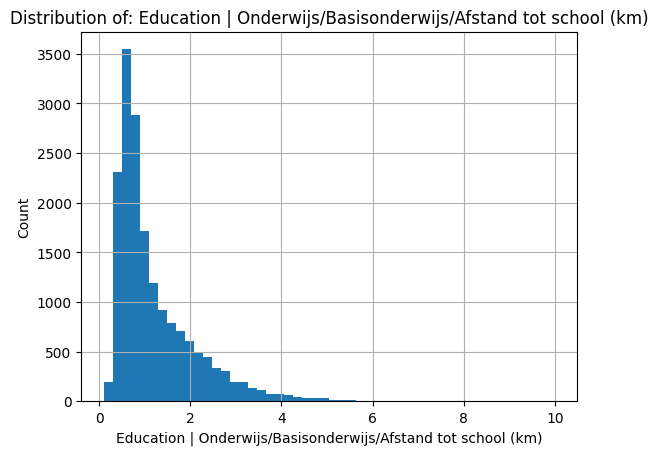

In [22]:

x_col = 'Education | Onderwijs/Basisonderwijs/Afstand tot school (km)'
plt.figure()
wide[x_col].dropna().hist(bins=50)
plt.title(f"Distribution of: {x_col}")
plt.xlabel(x_col)
plt.ylabel("Count")
plt.show()



<Figure size 640x480 with 0 Axes>

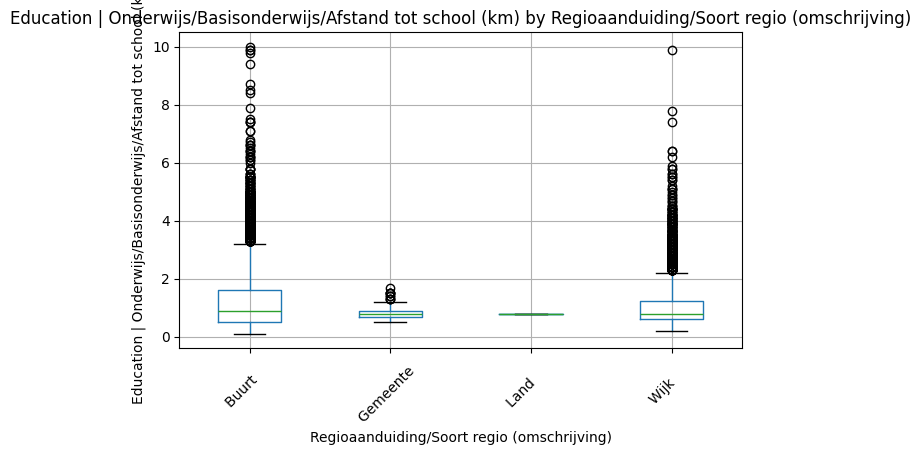

In [ ]:

region_type_col = "Regioaanduiding/Soort regio (omschrijving)"
if x_col is not None and region_type_col in wide.columns:
    # Use up to the 6 most frequent region types to keep the chart readable
    top_types = wide[region_type_col].value_counts().head(6).index
    df_box = wide.loc[wide[region_type_col].isin(top_types), [region_type_col, x_col]].dropna()
    plt.figure()
    df_box.boxplot(column=x_col, by=region_type_col, rot=45)
    plt.title(f"{x_col} by {region_type_col}")
    plt.suptitle("")  # remove automatic suptitle
    plt.xlabel(region_type_col)
    plt.ylabel(x_col)
    plt.tight_layout()
    plt.show()
